In [51]:
import pandas as pd
import numpy as np
import math
from scipy.stats import describe, randint
from scipy.interpolate import interp1d
import plotly.graph_objects as go
import os
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
import scipy.sparse
from scipy.optimize import least_squares
from sklearn.linear_model import LinearRegression

sns.set()

# Methods for exporting tables and images to latex
def saveimg(filename, fig):
    file_path = os.path.join(os.getcwd(), 'images')
    os.makedirs(file_path, exist_ok=True)
    fig.savefig(os.path.join(file_path, filename))
    
def savetable(filename, df):
    file_path = os.path.join(os.getcwd(), 'tables')
    os.makedirs(file_path, exist_ok=True)
    pd.DataFrame(df).to_latex(os.path.join(file_path, filename),escape = False, index = False)
    
val = [1,4,12,36,100,284,780,2172,5916,16268,44100,120292,324932,881500,2374444,6416596,17245332,46466676,124658732,335116620,897697164,2408806028,6444560484,17266613812,46146397316,123481354908,329712786220,881317491628]

# 3.

In [58]:
def random_neighbour(points):

    # Getting dimensions of points
    dimension = np.shape(points)
    
    # Generate if going up or down, do this for all points
    up_or_down = 2*np.random.randint(2, size=dimension[0]) - 1
    
    # Generate which diretion to go in for all points
    direction = np.random.randint(dimension[1], size=dimension[0])
    
    # Create new matrix, create a binary matrix of the direction
    indptr = range(len(direction)+1)
    data = np.ones(len(direction))
    points_to_change = scipy.sparse.csr_matrix((data, direction, indptr)).toarray()
    
    # Add the binary matrix multiplied by direction to the old points
    new_points = points + (points_to_change.T*up_or_down).T
    
    # Generating probabilities
    probabilities = np.ones(dimension[0])*1/(dimension[1]*2)
    
    return new_points, probabilities

def random_neighbour_avoiding(random_walks):
    
    # Start by swapping axis i and k so it is possible to iterate over all random walks
    random_walks_list = np.swapaxes(random_walks, 0, 1)
    
    # Creating lists for new points probabilities
    new_points = []
    probabilities = []
    
    # Iterate over random walks
    for random_walk in random_walks_list:
        
        # Making rw to list so it's possible to use 'not in'
        random_walk = random_walk.tolist()
        last_point = random_walk[-1]
        
        # Creating list for possible points
        viable_points = []
        
        # Get dimension for last point
        dimension = np.shape(last_point)[0]
        
        # Generate possible neigbours
        for n in range(dimension):
            
            change = np.zeros(dimension)
            change[n] = 1
            
            point_up = last_point - change
            point_down = last_point + change
            
            viable_points.append(list(point_up))
            viable_points.append(list(point_down))
        
        # Sort out points thats already in walk
        viable_points = list(filter(lambda x: x not in random_walk, viable_points))
        length = len(viable_points)
        
        # If no points left, append last one
        if length == 0:
            new_points.append(last_point)
            probabilities.append(0)
            
        # Select on of the remaining points and calculate probability
        else:   
            probabilities.append(1/length)
            new_point_index = np.random.randint(length, size=1)[0]
            new_points.append(viable_points[new_point_index])
        
    return new_points, probabilities

def is_self_avoiding(random_walk):
    return int(len(np.unique(random_walk, axis=0)) == len(random_walk))

def generate_weights(random_walks, weights, probabilities, do_resample=False):
        
    # Get indexes where probabilities is different from zero
    indexes_zero_prob = np.nonzero(probabilities)[0]
    
    # Get indexes where weights is different from zero
    indexes = np.intersect1d(np.nonzero(weights)[0], indexes_zero_prob)
    
    # Create new weights
    new_weights = np.zeros(len(weights))
    
    # Start by swapping axis i and k so it is possible to iterate over all random walks
    random_walks_list = np.swapaxes(random_walks, 0, 1)
    
    # Looping over and update weights
    if(do_resample):
        for index in indexes_zero_prob:
            new_weights[index] = is_self_avoiding(random_walks_list[index])/probabilities[index]
    else:
        for index in indexes:
            new_weights[index] = is_self_avoiding(random_walks_list[index])/probabilities[index]*weights[index]
        
    return new_weights      

def resample(random_walks, weights):
    
    # Calculate probabilities
    probabilities = weights/np.sum(weights)
    random_walks_list = np.swapaxes(random_walks, 0, 1)
    
    # Randomize replacement indices
    replacement_index = np.random.choice(np.arange(len(random_walks_list)), len(random_walks_list), p = probabilities)
    
    # Create resampled random_walks
    resamples_random_walks = list(map(lambda x: random_walks_list[x], replacement_index))
    
    return np.swapaxes(resamples_random_walks, 0, 1).tolist()

def init_walk (d, k, N, self_avoiding = False, do_resample = False):
    
    # The random_walk array has the following structure compared 
    # to the lecture notes random_walk[k][i][d], where:
    # k = step number k
    # i = simulation number
    # d = dimension 
    
    random_walks = []
    weights = [[1] * N]
    
    random_walks.append(np.zeros((N, d)))
    
    for step in range(k):
        
        if self_avoiding:
            step_all, probabilities = random_neighbour_avoiding(random_walks)
        else:
            step_all, probabilities = random_neighbour(random_walks[step])
            
        random_walks.append(step_all)
        weights.append(generate_weights(random_walks, weights[step], probabilities, do_resample=do_resample))
        
        if do_resample:
            random_walks = resample(random_walks, weights[-1])
            
        print("-", end="")
        
    if do_resample:
        return np.cumprod(np.mean(weights[1:], axis=1))
    else:
        return np.mean(weights[1:], axis=1)
    
def estimate_parameters(cn):
    
    length = len(cn)
    
    # Finding optimal parameters
    y = np.log(cn)
    X = np.hstack((np.ones(length), np.arange(length) + 1, np.log(np.arange(length) + 1))).reshape(3,length).T
    theta =(np.linalg.inv(X.T@X)@X.T)@y

    # Un transform
    theta = [np.e**theta[0], np.e**theta[1], theta[2] + 1]
    
    return theta 

In [59]:
cn = init_walk(2, 30, 10**3, self_avoiding=True, do_resample=True)

print(cn)

------------------------------[4.00000000e+00 1.20000000e+01 3.60000000e+01 1.00800000e+02
 2.88792000e+02 7.97643504e+02 2.25174761e+03 6.13150875e+03
 1.69107011e+04 4.60309285e+04 1.25158094e+05 3.40680333e+05
 9.18814859e+05 2.47804367e+06 6.62381074e+06 1.80631319e+07
 4.88246455e+07 1.32656562e+08 3.59101313e+08 9.60955113e+08
 2.62725128e+09 7.06993319e+09 1.85585746e+10 4.94214842e+10
 1.31016355e+11 3.50075700e+11 9.34001967e+11 2.49285125e+12
 6.67834850e+12 1.78645822e+13]


In [57]:
n = 100

cn = init_walk(2, n, 10**4, self_avoiding=True, do_resample=True)
print(estimate_parameters(cn))


----------------------------------------------------------------------------------------------------[1.4281319712329137, 2.639403123827856, 1.2815042854383822]


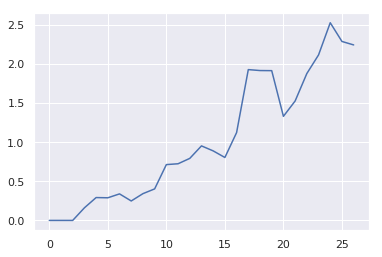

In [55]:
plt.plot(np.abs(cn - val[1:n+1])/val[1:n+1]*100)

In [417]:
np.array(val[:21]) - np.array(cn)

array([ 0.00000000e+00,  3.00000000e+00,  1.10000000e+01,  3.20000000e+01,
        5.20000000e+01, -1.44400000e+03, -1.72407072e+05, -4.92931311e+07,
       -3.90488955e+10, -8.74146565e+13, -5.39897593e+17, -9.17337437e+21,
       -4.23015896e+26, -5.25120911e+31, -1.71376995e+37, -1.48102953e+43,
       -3.37636741e+49, -2.02591663e+56, -3.13140540e+63, -1.25843379e+71,
       -1.30732026e+79])

In [24]:
cn

array([1.00000000e+00, 4.00000000e+00, 1.20000000e+01, 3.60000000e+01,
       9.94752000e+01, 2.83564005e+02, 7.77248938e+02, 2.15981935e+03,
       5.87298077e+03, 1.60344121e+04, 4.27669840e+04, 1.14846459e+05,
       3.03447313e+05, 8.01404355e+05, 2.08894059e+06, 5.45944623e+06,
       1.40138525e+07, 3.58516389e+07, 9.08623937e+07, 2.29927287e+08,
       5.77508368e+08, 1.43788033e+09, 3.55142064e+09, 8.74217704e+09,
       2.12810816e+10, 5.13235844e+10, 1.22345161e+11, 2.90753274e+11,
       6.82194407e+11, 1.58671597e+12, 3.66214046e+12, 8.37348416e+12,
       1.89584055e+13, 4.24554533e+13, 9.40345834e+13, 2.07656571e+14,
       4.52795152e+14, 9.81750449e+14, 2.11370872e+15, 4.51699553e+15,
       9.61081138e+15, 2.01817428e+16, 4.21314063e+16, 8.68496810e+16,
       1.77390473e+17, 3.58843189e+17, 7.17829915e+17, 1.42187749e+18,
       2.76711579e+18, 5.37373887e+18, 1.03379988e+19])

In [23]:
cn[32]/10**13

1.895840549256494